[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_25257/2807662515.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(self.stock.diff().dropna().mean())
/tmp/ipykernel_25257/2807662515.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(self.stock.diff().dropna().std())
/tmp/ipykernel_25257/2807662515.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(self.stock.diff().dropna().std())
/tmp/ipykernel_25257/2807662515.py:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = float(self.stock.iloc[0]) * np.exp(X)
/tmp/ipyker

<Figure size 1200x600 with 0 Axes>

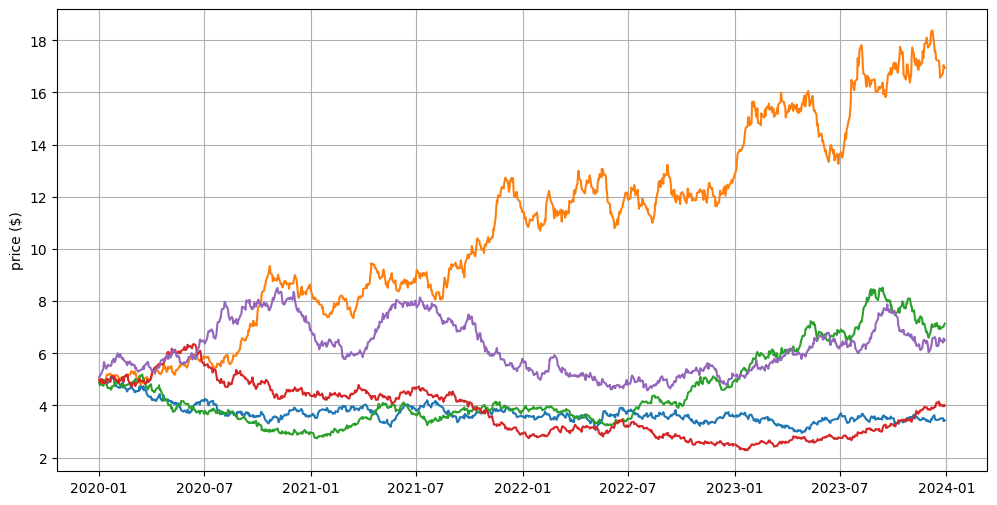

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


class yfinance_stock:
    def __init__(self, data):
        self.data = data
        self.date = data.index
        self.stock = data['Close']
        self.models = None
        self.func = self.geometric_brownian_motion
    
    def close(self):
        self.stock = self.data['Close']
        return self
    def open(self):
        self.stock = self.data['Open']
        return self
    def high(self):
        self.stock = self.data['High']
        return self
    def low(self):
        self.stock = self.data['Low']
        return self
    
    def log(self):
        self.stock = self.stock.apply(np.log)
        return self    
    def diff(self):
        self.stock = self.stock.apply(np.diff)
        return self
            
    def return_rate(self):
        return float(self.stock.mean())
    def vol_return(self):
        return float(self.stock.std())
    def drift(self):
        return float(self.stock.diff().dropna().mean())
    def vol_drift(self):
        return float(self.stock.diff().dropna().std())
    
    def line(self):
        plt.figure(figsize=(12, 6))
        for model in self.models:
            plt.plot(self.date, model)
        plt.ylabel('price ($)')
        plt.grid(True)
        plt.show
        return self.line
    
    def simulation(self, n):
        models = []
        for i in range(n):
            S = self.func()
            models.append(S)
        self.models = models
        return self.models
    
    def geometric_brownian_motion(self):
        t = np.arange(len(self.date))
        W = np.random.standard_normal(len(self.date))
        W = np.cumsum(W)
        X = (self.drift() - 0.5 * self.vol_drift()**2) * t + self.vol_drift() * W
        S = float(self.stock.iloc[0]) * np.exp(X)
        self.func = self.geometric_brownian_motion
        return S
    
    def stochastic_variance(self):
        

# 使用例
if __name__ == "__main__":
    # # サンプルデータ（AAPL株価）の取得
    stock_data = yf.download('TM', start='2020-01-01', end='2023-12-31')
    
    # yfinance_stockクラスのインスタンス
    data = yfinance_stock(stock_data)
    print(data.close())
    data.close().log()
    plt.figure(figsize=(12, 6))
    data.close().log().geometric_brownian_motion()
    data.simulation(5)
    data.line()